# Basic Abstraction And Presentation



## Assumptions


### 1. Code in `CODE_ROOT_FOLDER`

In [2]:
# change to point to the right folder on your mahchine where you cloned the Zeeguu-Core
CODE_ROOT_FOLDER = '/Users/mircea/Zeeguu-Core/'

# And a helper function to construct
# the full path of a file by adding the CODE_ROOT_FOLDER

def full_path(file_name, root_folder=CODE_ROOT_FOLDER):
    return root_folder+file_name

### 2. All the imports and functions from [DataGathering_Intro](Data_Gathering_Intro.ipynb)

In [3]:
import sys
import pathlib
from pathlib import Path
import re
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
def LOC(file):
    return sum([1 for line in open(file)])

In [5]:
import re

def imports_in_text(module_text):
    regex = r"^(import|from)\s(\S+)"
    return set(
        match[1]
        for match in re.findall(regex,
                                module_text,
                                re.MULTILINE)
    )

def imports(file_name):
    with open(file_name) as f:
        return imports_in_text(f.read())
    

assert ("x" in imports_in_text("from x import y\nimport z"))
assert ("sqlalchemy" in imports(full_path('zeeguu_core/model/user.py')))

In [232]:
def module_from_file_path(folder_prefix, full_path):
    # extracting a module from a file name
    # e.g. /Users/mircea/Zeeguu-Core/zeeguu_core/model/user.py -> zeeguu_core.model.user
    
    file_name = full_path[len(folder_prefix):]
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

def module(full_path):
    return module_from_file_path(CODE_ROOT_FOLDER, full_path)

assert 'zeeguu_core.model.user' == module(full_path('zeeguu_core/model/user.py'))

In [233]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.Graph()

    for file in files:
        m = module(str(file))
        if m not in G.nodes:
            G.add_node(m)

        for each in imports(str(file)):
            G.add_edge(m, each)

    return G

In [234]:
def draw_graph(G):
    plt.figure(figsize=(10,6))
    nx.draw(G)
    plt.show()

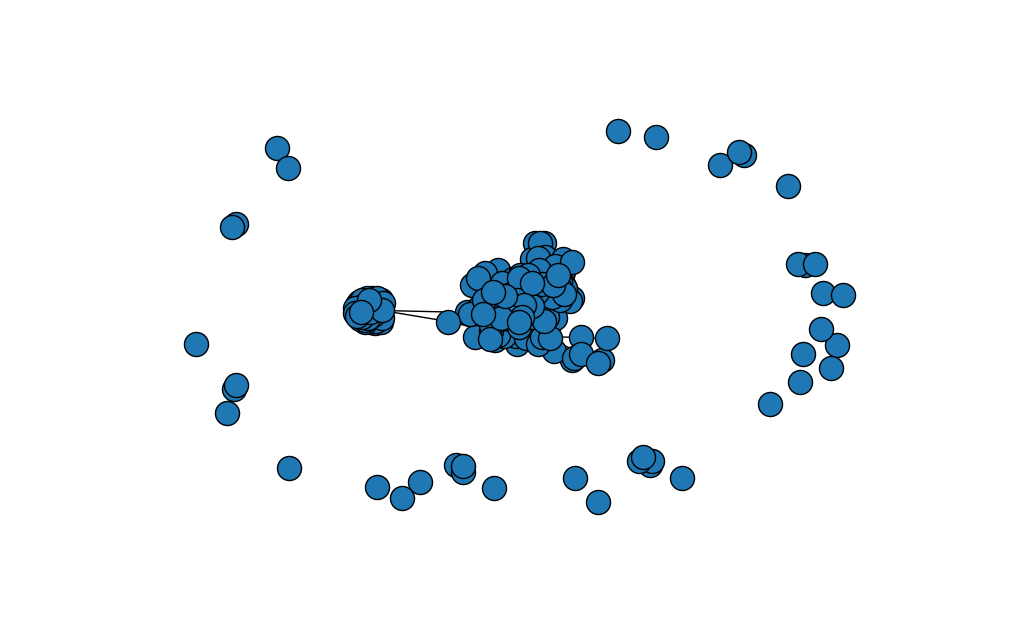

In [235]:
G = dependencies_graph()
draw_graph(G)

# 1. Basic Abstraction

### Aggregating Dependencies


In [236]:
def top_level_module(module_name, depth=1):
    # extracts the parent of depth X 
    # e.g. top_level_module(zeeguu_core.model.util, 1) -> zeeguu_core
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_module("zeeguu_core.model.util") == "zeeguu_core")
assert (top_level_module("zeeguu_core.model.util", 2) == "zeeguu_core.model")

In [237]:
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))
    return aG

In [238]:
def draw_graph_with_labels(G, figsize=(10,10)):
    plt.figure(figsize=figsize)
    nx.draw(G,with_labels=True)
    plt.show()

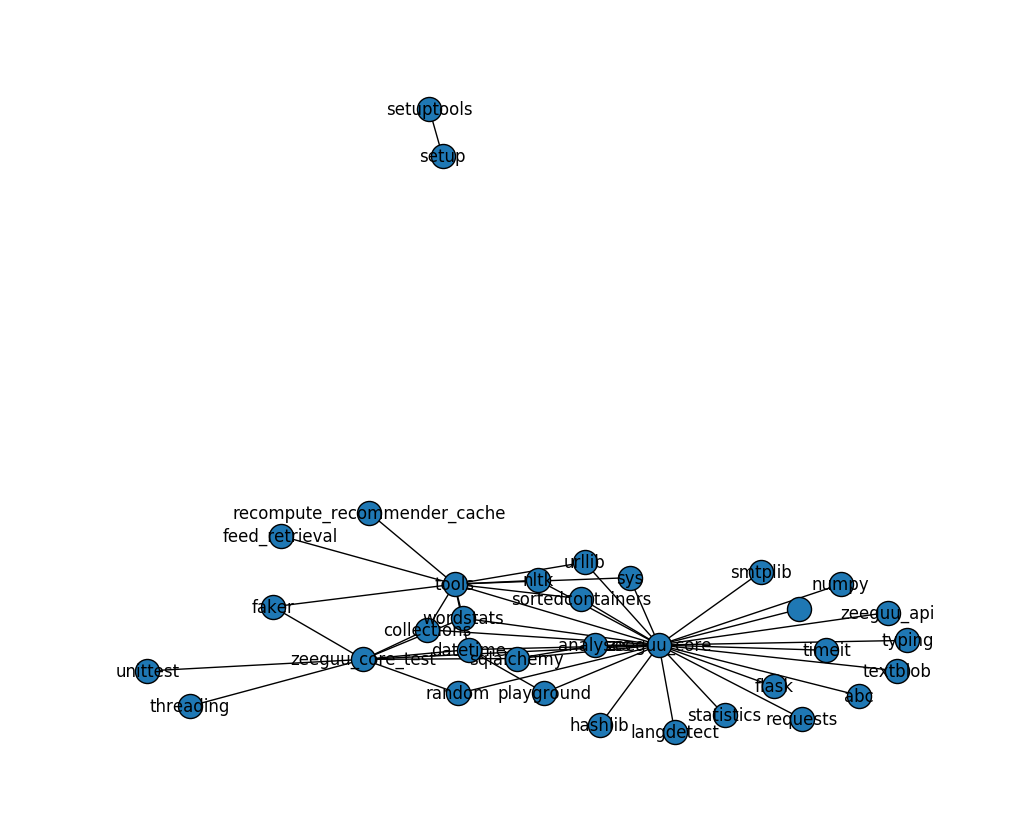

In [239]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph_with_labels(aG, (10,8))

## Distinguishing System Modules 

In [255]:

def system_module(m):
    return m.startswith('zeeguu')

In [256]:
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if system_module(source) and system_module(destination):
            aG.add_edge(source, destination)
    return aG

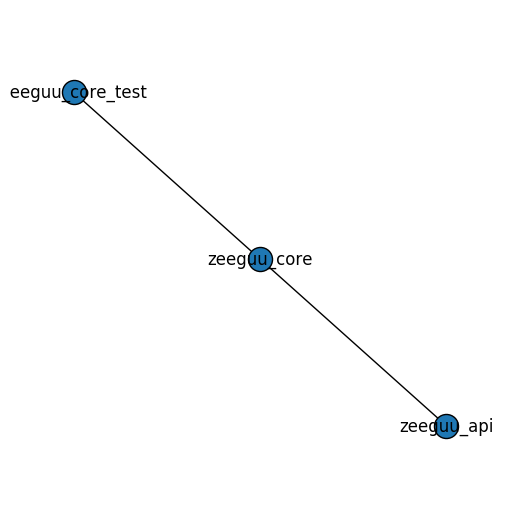

In [257]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph_with_labels(aG, (5,5))

## But Dependencies Have Directions...



In [199]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        m = module(str(file))
        if m not in G.nodes:
            G.add_node(m)

        for each in imports(str(file)):
            G.add_edge(m, each)

    return G

In [200]:
def abstracted_to_top_level(G):
    aG = nx.DiGraph()
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if system_module(source) and system_module(destination):
            aG.add_edge(source, destination)
    return aG

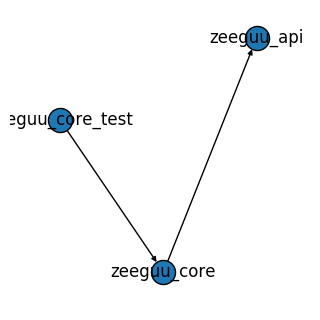

In [201]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_labels(directedAbstracted, (3,3))

### Oooops. Something unexpected ... 



## Capturing all the modules... e.g. tools

In [202]:
def system_module(m):
    return m.startswith('zeeguu') or m=='tools' or m=='playground'

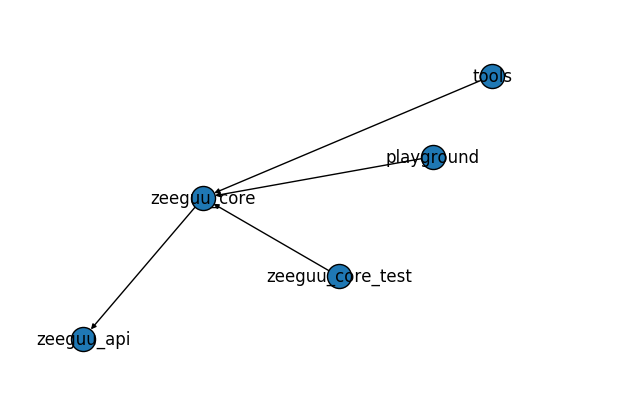

In [203]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_labels(directedAbstracted, (6,4))

# 2. Basic Presentation

### Remember the Definition of Architecture
- includes properties of modules


In [204]:
def module_size(m):
    size = 0
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    for file in files:
        module_name = module(str(file))
        if module_name.startswith(m + '.'):
            size += LOC(str(file))
            
    return size

module_size("zeeguu_core")
module_size("zeeguu_core_test")
module_size("zeeguu_api")

0

In [205]:
def draw_graph_with_weights(G, weight_function, figsize=(10,10)):
    
    node_weights = [weight_function(each) for each in G.nodes]
    
    plt.figure(figsize=figsize)
    nx.draw(G,
            with_labels=True,
            node_size=node_weights)
    plt.show()

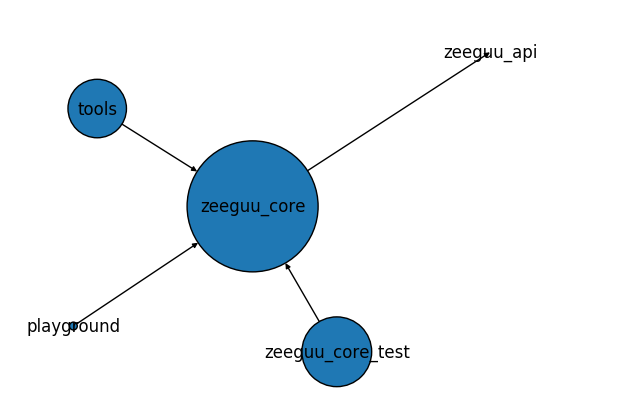

In [206]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_weights(directedAbstracted, module_size, (6,4))

## Interactive Assignment
- draw the architecture of the zeeguu_core itself!
- i.e. expand to the top level modules in zeeguu core


In [207]:
def system_module(m):
    modules = ['zeeguu_core.bookmark_quality',
              'zeeguu_core.configuration',
              'zeeguu_core.content_recommender',
              'zeeguu_core.content_retriever',
              'zeeguu_core.model',
              'zeeguu_core.language',
              'zeeguu_core.emailer',
              'zeeguu_core.util',
              'zeeguu_core.word_scheduling']
    return m in modules or m=='tools' or m=='playground'

In [208]:
def abstracted_to_top_level(G):
    aG = nx.DiGraph()
    for each in G.edges():
        source = top_level_module(each[0],2)
        destination = top_level_module(each[1],2)
        if system_module(source) and system_module(destination):
            aG.add_edge(source, destination)
    return aG

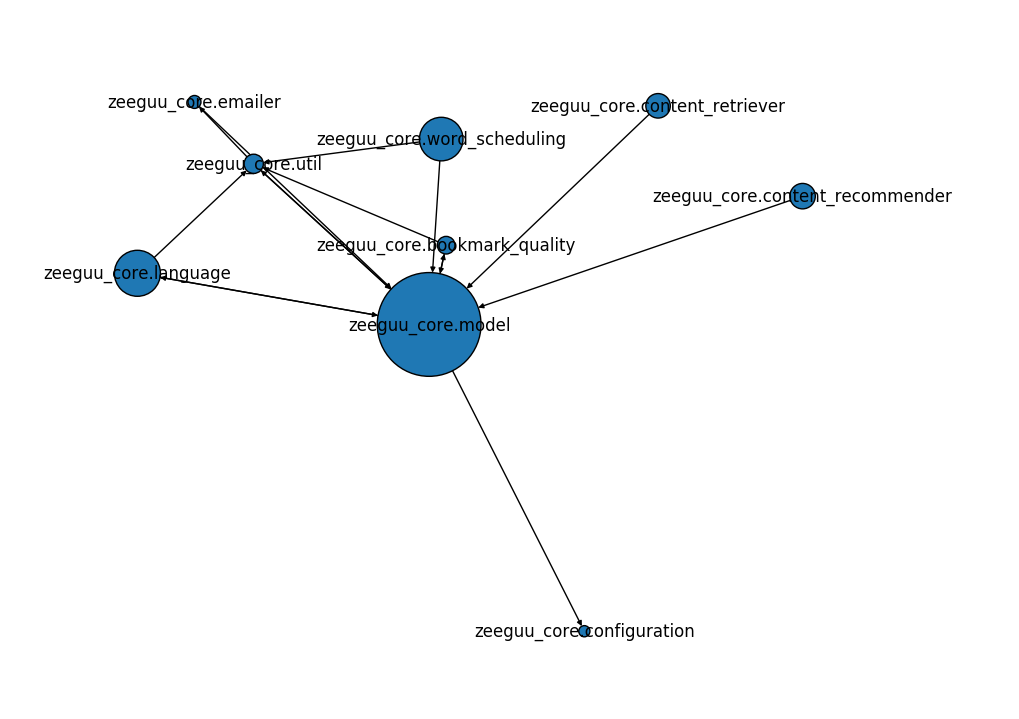

In [209]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_weights(directedAbstracted, module_size, (10,7))

### What do we observe
  - a circular dependency
  - a module called util - bad
  - to tell the story we need 
    - nouns and verbs
      - if nodes are nouns:
      - verbs = ???

### To Try Out: 
- can you export this to another interactive exploration tool?

In [210]:
def module_color(module):
    if system_module(module):
        return '#36a10b'
    return '#36a10b'
    